In [1]:
import os
import numpy as np
import pandas as pd
from Bio.PDB.Polypeptide import three_to_index
from Bio.PDB.Polypeptide import one_to_three

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = np.array([10,6.180])    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'

In [375]:
def get_filtered_B_inv_lambda_and_P(filtered_lamb, cutoff_mode, P, method='extend_all_after_first_noisy_mode'):
    if method == 'zero_all_after_first_noisy_mode':
        filtered_lamb_inv = 1 / filtered_lamb
        # for "zeroing unreliable eigenvalues"
        filtered_lamb_inv[cutoff_mode:] = 0.0
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(filtered_lamb_inv), np.linalg.inv(P)))
        filtered_lamb = 1 / filtered_lamb_inv
    if method == 'extend_all_after_first_noisy_mode':
        # for "extending lowest reliable eigenvalue"
        filtered_lamb[cutoff_mode:] = filtered_lamb[cutoff_mode - 1]
        filtered_B_inv = np.dot(
            P, np.dot(np.diag(1 / filtered_lamb), np.linalg.inv(P)))

    return filtered_B_inv, filtered_lamb, P


def sort_eigenvalues_and_eigenvectors(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors


def get_A_B(pre, n=201, first_half=False, second_half=False,):
    # pre = "/Users/weilu/Research/server/aug_2020/curated_single_chain_optimization/optimization_msa_mode_3/gamma_mode_3"
    A = np.load(f"{pre}/average_A.npy", allow_pickle=True)
    B = np.load(f"{pre}/average_B.npy", allow_pickle=True)
    A_prime = np.load(f"{pre}/average_A_prime.npy", allow_pickle=True)
    # half_B = np.load(f"{pre}/average_half_B.npy", allow_pickle=True)
    # other_half_B = np.load(f"{pre}/average_other_half_B.npy", allow_pickle=True)
    # std_half_B = np.load(f"{pre}/average_std_half_B.npy", allow_pickle=True)
#     A = A[:n]
#     B = B[:n,:n]
#     A_prime = A_prime[:n]
#     half_B = half_B[:n,:n]
#     other_half_B = other_half_B[:n, :n]
#     std_half_B = std_half_B[:n, :n]
    if second_half:
        half_n = int(n/2)
        A = A[half_n:]
        B = B[half_n:,half_n:]
        A_prime = A_prime[half_n:]
        # half_B = half_B[half_n:,half_n:]
        # other_half_B = other_half_B[half_n:, half_n:]
        # std_half_B = std_half_B[half_n:, half_n:]
    A_B_dic = {}
    A_B_dic["A"] = A
    A_B_dic["B"] = B
    # A_B_dic["half_B"] = half_B
    # A_B_dic["other_half_B"] = other_half_B
    # A_B_dic["std_half_B"] = std_half_B
    A_B_dic["A_prime"] = A_prime
    return A_B_dic

def get_gamma(A, B, A_prime, c=-100, cutoff_range=range(100, 210, 10)):
    gamma_cutoff_dic = {}
    for cutoff in list(cutoff_range):
        # cutoff = 400
        lamb, P = np.linalg.eig(B)
        lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
        filtered_lamb = np.copy(lamb)
        cutoff_mode = cutoff
        filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                           cutoff_mode, P)
        B_inv = filtered_B_inv
        lambda_2 = (A_prime.dot(B_inv).dot(A) - c) / (A_prime.dot(B_inv).dot(A_prime))
        gamma_new = B_inv.dot(A-A_prime*lambda_2)
        gamma_cutoff_dic[cutoff] = gamma_new
    return gamma_cutoff_dic

In [342]:
A = np.load(f"{pre}/average_A.npy", allow_pickle=True)
B = np.load(f"{pre}/average_B.npy", allow_pickle=True)
A_prime = np.load(f"{pre}/average_A_prime.npy", allow_pickle=True)
A_B_dic = {}
A_B_dic["A"] = A
A_B_dic["B"] = B
A_B_dic["A_prime"] = A_prime

In [402]:
a = np.load("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_22/A_B_dic/1py6_A.npy", allow_pickle=True).item()

In [412]:
A_B = a
A = A_B['A'][690:]
B = A_B['B'][690:,690:]
A_prime = A_B['A_prime'][690:]

cutoff_range = [2000]
gamma_only_one = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

/Users/weilu/anaconda/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


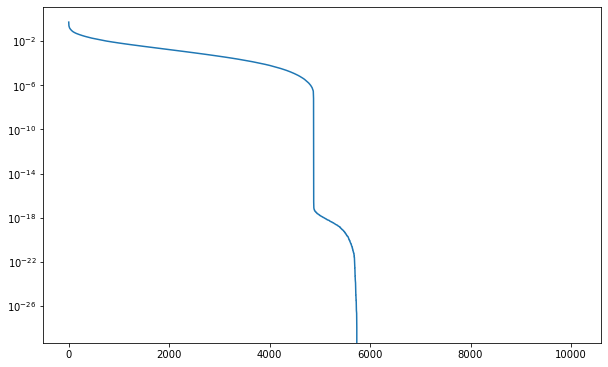

In [408]:
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")

In [413]:
x = gamma_only_one[2000]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

(4.485722136071037+2.4607160439159085e-15j) (4.95990956745995-3.731586786667099e-15j) (22.24877613966562-4.5339324026020856e-15j) (-66.00000000000006-1.6848465478471488e-29j)


In [411]:
x = gamma_only_one[4000]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

(9.096374302130384+4.157308412715386e-14j) (6.874996086020237-3.1165731823310925e-15j) (62.53753772412146+2.5746527445150757e-13j) (-66.00000000000031+1.797635144292163e-28j)


In [403]:
np.random.choiceiceice

<module 'numpy.random' from '/Users/weilu/anaconda/lib/python3.6/site-packages/numpy/random/__init__.py'>

In [414]:
# Mode 23, using shuffling based optimization.

In [415]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_23/gamma/"
mode_23 = get_A_B(pre, n=10790)

In [427]:
A_B = mode_23
A = A_B['A']
B = A_B['B']
A_prime = A_B['A_prime']

# cutoff_range=list(range(400, 700, 20))
cutoff_range = [8000]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_23_complete = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

In [428]:
x = gamma_mode_23_complete[8000]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

6.241829703274106 6.2244100697385445 38.851707658652494 -65.99999999999858


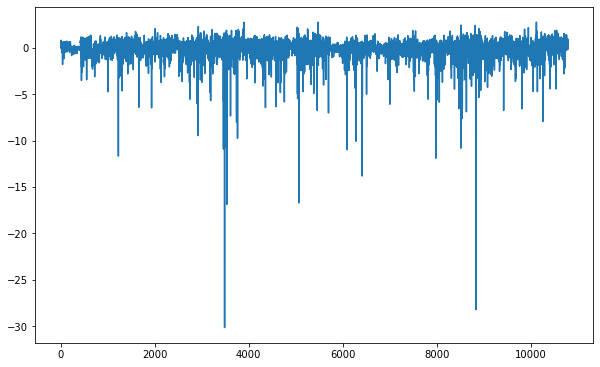

In [429]:
plt.plot(x)

In [416]:
A_B = mode_23
A = A_B['A'][690:]
B = A_B['B'][690:,690:]
A_prime = A_B['A_prime'][690:]

# cutoff_range=list(range(400, 700, 20))
cutoff_range = [8000]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_23 = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

In [418]:
x = gamma_mode_23[8000]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

3.252184440960937 7.138165586027292 23.21463105588077 -66.0


In [420]:
A_B = mode_23
A = A_B['A'][:690]
B = A_B['B'][:690:,:690]
A_prime = A_B['A_prime'][:690]
cutoff_range = [600]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_23_contact = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

In [422]:
x = gamma_mode_23_contact[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.835018204823044 4.890391064560418 23.645129825853562 -65.99999999999977


In [425]:
A_B = mode_23
A = A_B['A'][:210]
B = A_B['B'][:210:,:210]
A_prime = A_B['A_prime'][:210]
cutoff_range = [200]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_23_direct = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

In [426]:
x = gamma_mode_23_direct[200]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

2.143895680275977 3.3345516848657666 7.148930952840698 -65.99999999999999


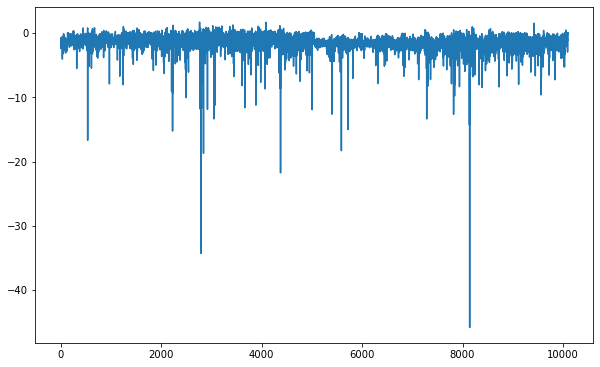

In [419]:
plt.plot(x)

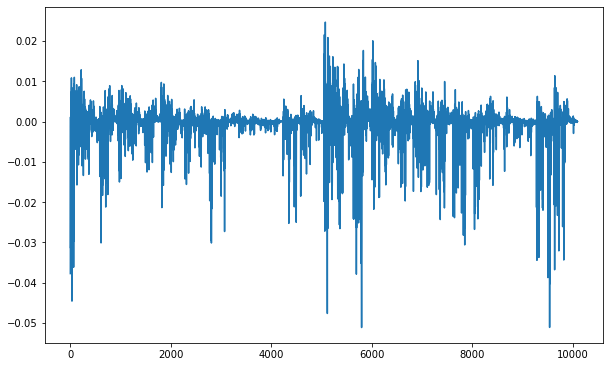

In [417]:
plt.plot(mode_23['A'][690:])

# mode 22, using ten letter code

In [396]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_22/with400_protein_gammas/"
mode_22_400 = get_A_B(pre, n=10790)

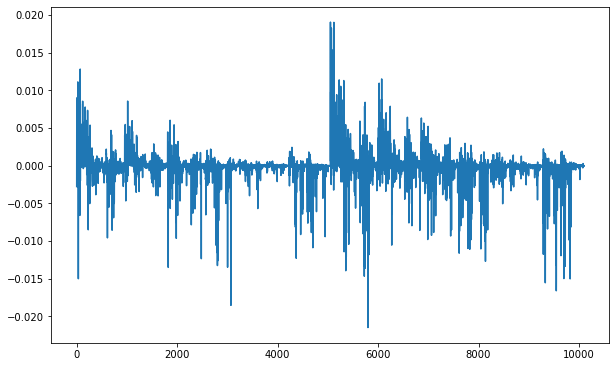

In [398]:
plt.plot(mode_22_400['A'][690:])

In [399]:
A_B = mode_22_400
A = A_B['A'][690:]
B = A_B['B'][690:,690:]
A_prime = A_B['A_prime'][690:]

# cutoff_range=list(range(400, 700, 20))
cutoff_range = [8000]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_22_400 = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

In [401]:
x = gamma_mode_22_400[8000]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.5773582292397449 2.8725031142987127 1.6584633115571572 -66.0


In [376]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_22/gamma/"
mode_22 = get_A_B(pre, n=10790)

In [388]:
A = A_B['A'][690:]
B = A_B['B'][690:,690:]
A_prime = A_B['A_prime'][690:]

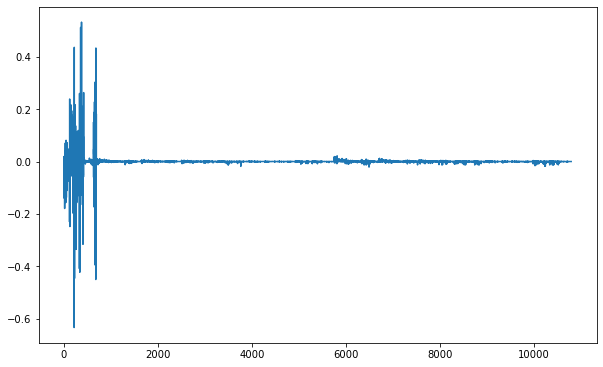

In [393]:
plt.plot(A_B['A'])

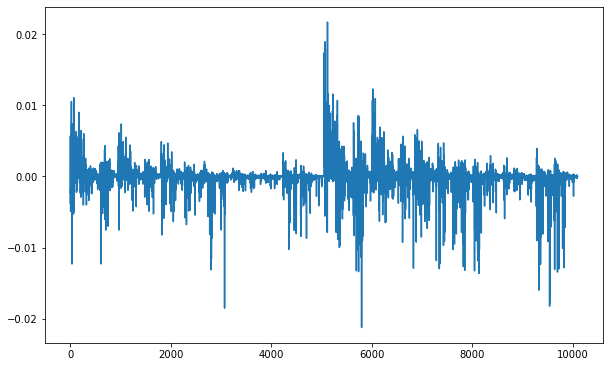

In [394]:
plt.plot(A)

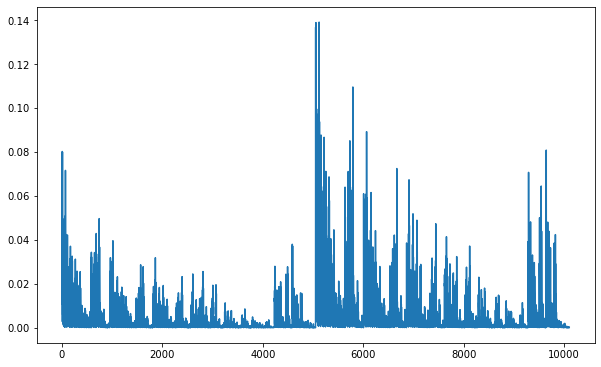

In [395]:
plt.plot(A_prime)

In [389]:
A_B = mode_22
# cutoff_range=list(range(400, 700, 20))
cutoff_range = [8000]
# gamma_mode_22 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)
gamma_mode_22 = get_gamma(A, B, A_prime, c=-66, cutoff_range=cutoff_range)

In [391]:
x = gamma_mode_22[8000]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.7335323632693906 2.831298185588163 2.076848849194823 -65.99999999999999


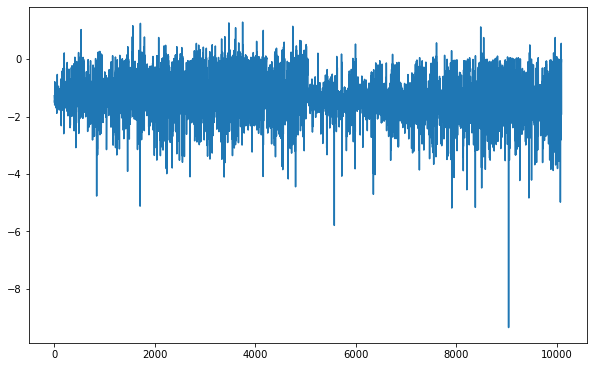

In [392]:
plt.plot(x)

In [382]:
compute_z(mode_22, gamma_mode_22[8000])

1.6076399225935498 1.7017467013134844 2.7357959351734387 -66.00000000000043


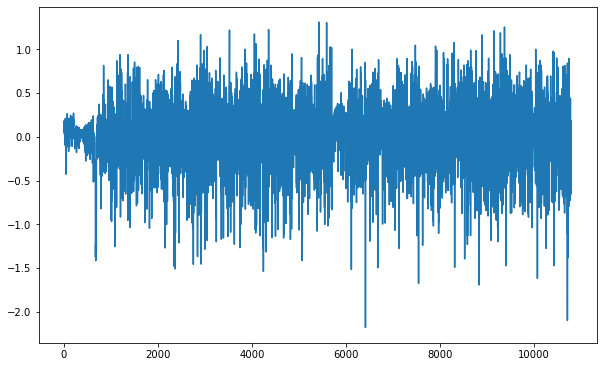

In [383]:
plt.plot(gamma_mode_22[8000])
# plt.plot(gamma_mode15[400], alpha=0.5)

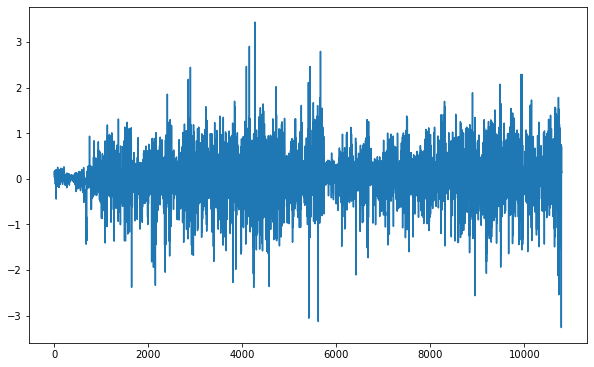

In [380]:
plt.plot(gamma_mode_22[10000])
# plt.plot(gamma_mode15[400], alpha=0.5)

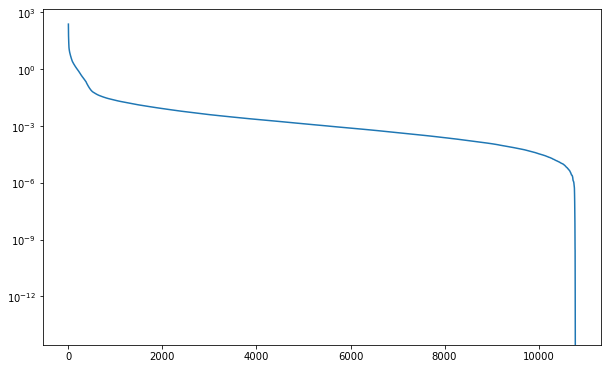

In [378]:
A_B = mode_22
B = A_B['B']
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")

In [385]:
toLocation = "/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder"
x = gamma_mode_22[8000]
np.savetxt(f"{toLocation}/ten_letter_contact.dat", x[:690])
np.savetxt(f"{toLocation}/ten_letter_fourbody.dat", -x[690:])
np.savetxt(f"{toLocation}/ten_letter_all.dat", x)

# New CB gamma, mode 21

In [359]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_21/gamma/"
mode_21 = get_A_B(pre, n=690)

In [360]:
A_B = mode_21
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_21 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)

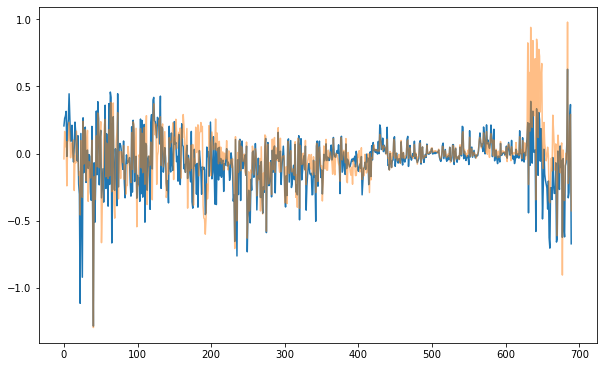

In [367]:
plt.plot(gamma_mode_21[400])
plt.plot(gamma_mode15[400], alpha=0.5)

In [370]:
compute_z(mode_21, gamma_mode_21[400])

4.311844968985882 4.335407723071658 18.693605979229066 -65.99999999999999


In [372]:
compute_z(mode_21, gamma_mode_21[520])

4.498743152241165 4.612498208320348 20.750444729405807 -66.00000000000004


In [371]:
compute_z(mode_21, gamma_mode15[400])

3.194146643845733 4.4751741366085644 14.294362449073473 17.565524211585334


In [369]:
compute_z(mode_21, gamma_iter_mixed_iter1_new_mode15_all_prime_2[400])

0.5447423914757136 3.6302592922565413 1.9775561285407597 -99.99484666061232


# Specific iterative optimization

In [349]:

pre = "/Users/weilu/Research/server/oct_2020/iterative_optimization/mixed_iter1_new_mode15_all_prime_2/gamma/"
iter_mixed_iter1_new_mode15_all_prime_2 = get_A_B(pre, n=690)

In [350]:
A_B = iter_mixed_iter1_new_mode15_all_prime_2
cutoff_range=list(range(400, 700, 20)) 
gamma_iter_mixed_iter1_new_mode15_all_prime_2 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)

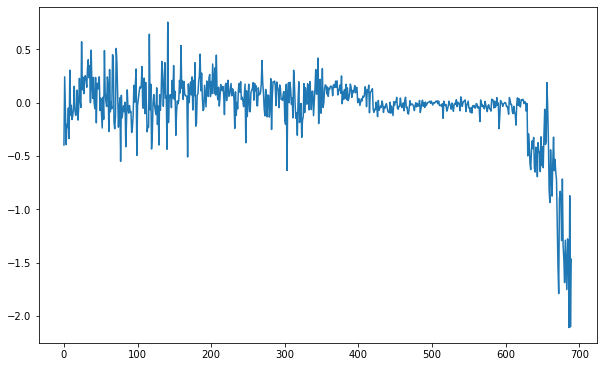

In [355]:
plt.plot(gamma_iter_mixed_iter1_new_mode15_all_prime_2[400])

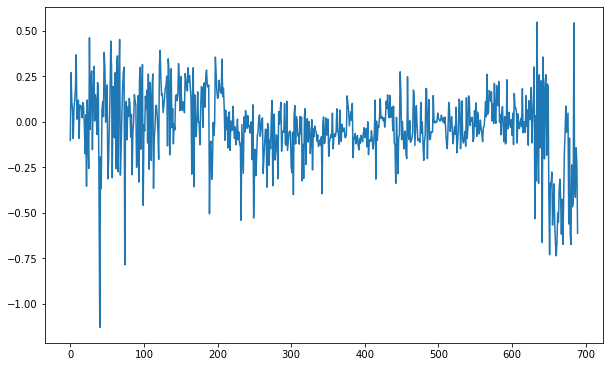

In [356]:
plt.plot(mixed_x)

In [354]:
compute_z(iter_mixed_iter1_new_mode15_all_prime_2, gamma_iter_mixed_iter1_new_mode15_all_prime_2[400])

3.416371128025681 5.857827104314473 20.012511392146244 -65.99999999999999


In [353]:
compute_z(iter_mixed_iter1_new_mode15_all_prime_2, mixed_x)

-0.5037822578924191 7.0321721966571475 -3.5426835871202305 -79.15891716771311


In [294]:
pre = "/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_2/gamma/"
iter_mode2 = get_A_B(pre, n=690)

In [328]:
A_B = iter_mode2
cutoff_range=list(range(400, 700, 20)) 
gamma_iter_mode2 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-66, cutoff_range=cutoff_range)

In [329]:
# z score
A_B = iter_mode2
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_iter_mode2[400]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

3.3710450304800084 4.953200562917806 16.69746214259485 -66.00000000000001


In [325]:
new_mode15_all_prime = np.loadtxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/new_mode15_all_prime.dat")

In [330]:
# z score
A_B = mode_15
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_iter_mode2[400]
x = new_mode15_all_prime
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.44948869404758 4.719643411633881 21.000000000001105 -66.08984543497455


In [331]:
# z score
A_B = mode_15
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_iter_mode2[400]
# x = new_mode15_all_prime
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.7790097413219759 4.409387512537042 3.4349558255298316 -93.21033280789992


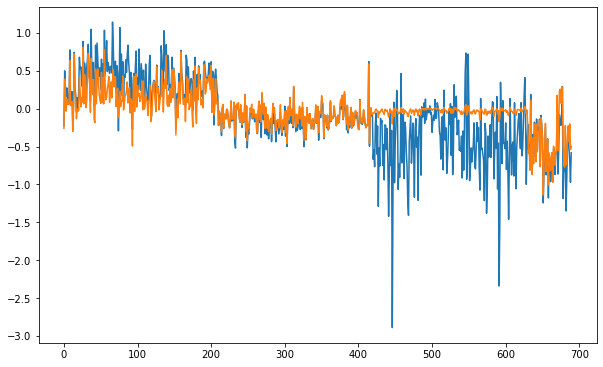

In [321]:
plt.plot(gamma_iter_mode2[500] )
plt.plot(gamma_iter_mode2[400] )

In [343]:
alpha = 0.4
mixed_x = alpha * gamma_iter_mode2[400]  + (1 - alpha) * new_mode15_all_prime

In [344]:
compute_z(iter_mode2, mixed_x)

0.954617463028819 6.249380250202495 5.965767519950711 -69.11502655446697


In [345]:
compute_z(mode_20_weighted, mixed_x)

0.9750980790897108 3.7928847762932736 3.6984346595721784 -88.5930206176874


In [347]:
compute_z(mode_15, mixed_x)

3.82921577028737 3.6493065861273974 13.973982330212595 -76.93804038414471


In [348]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/mixed_iter1_new_mode15_all_prime.dat", mixed_x)

In [336]:
# z score
A_B = mode_15
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_iter_mode2[400]
# x = new_mode15_all_prime
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.44948869404758 4.719643411633881 21.000000000001105 -66.08984543497455


In [339]:
# z score
A_B = mode_20_weighted
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_iter_mode1[400]
# x = new_mode15_all_prime
# x = gamma_mode_20_weighted[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.2348038863357502 5.265863960387635 6.502309283202017 -81.67709844922514


In [276]:
pre = "/Users/weilu/Research/server/oct_2020/iterative_optimization/optimization_specific_decoy_msa_submode_1/gamma/"
iter_mode1 = get_A_B(pre, n=690)

In [277]:
A_B = iter_mode1
cutoff_range=list(range(400, 700, 20)) 
gamma_iter_mode1 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-100, cutoff_range=cutoff_range)

In [280]:
# z score
A_B = iter_mode1
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_iter_mode1[400]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

15.943918622372337 15.475615679570494 246.74195702618132 -99.99999999999999


In [291]:
alpha = 0.05
x = alpha * gamma_iter_mode1[400]  + (1 - alpha) * gamma_mode_20_weighted[600]

In [292]:
# z score
A_B = iter_mode1
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_iter_mode1[400]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.030300733463957705 5.841683421413757 0.17700729233307877 -94.76536650117568


In [293]:
# z score
A_B = mode_20_weighted
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_iter_mode1[400]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.5075052880027688 2.2537847471817183 1.1438076772147054 -113.59210746885668


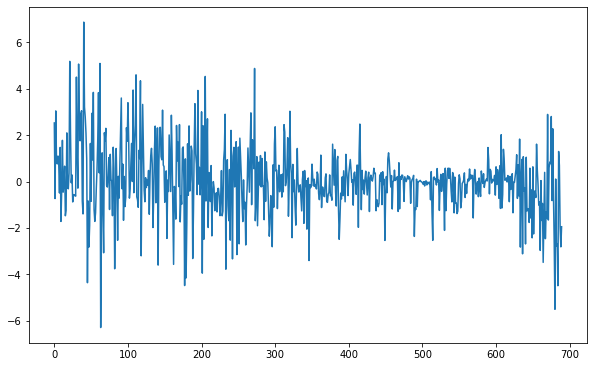

In [281]:
plt.plot(x)

In [278]:
# z score
A_B = iter_mode1
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode_20_weighted[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

-2.094938783766158 6.110009239614448 -12.800095325237882 -94.48985947492179


# Using the Helix Swapping method

## weighted differently

In [265]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_20/with_weighted_gamma/"
mode_20_weighted = get_A_B(pre, n=690)

In [266]:
A_B = mode_20_weighted
cutoff_range=list(range(400, 700, 20)) 
gamma_mode_20_weighted = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-100, cutoff_range=cutoff_range)

In [267]:
# z score
A_B = mode_20_weighted
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode_20_weighted[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.3131035441155132 1.766509739058924 2.3196101990728435 -100.00000000000004


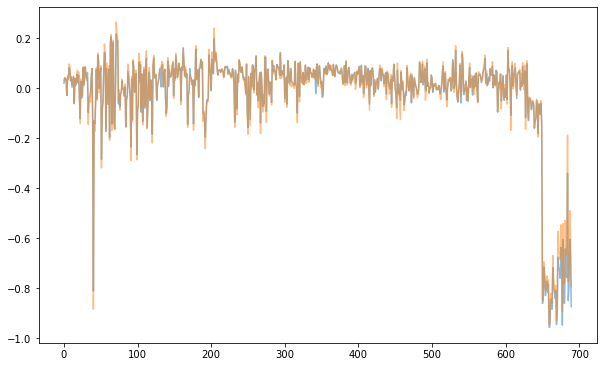

In [268]:
plt.plot(gamma_mode20[600][:690], alpha=0.5)
plt.plot(gamma_mode_20_weighted[600][:690], alpha=0.5)

## max swaping to 5

In [218]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_20/gamma/"
mode_20 = get_A_B(pre, n=690)

In [241]:
A_B = mode_20
cutoff_range=list(range(400, 700, 20)) 
gamma_mode20 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-100, cutoff_range=cutoff_range)

In [242]:
# z score
A_B = mode_20
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode20[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.1476418718153238 1.6652828073438704 1.9111482781219966 -99.99999999999999


In [239]:
x = np.loadtxt("/Users/weilu/opt/parameters/original_membrane_gamma")

In [240]:
# z score
A_B = mode_20
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_mode20[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.4147311331317683 10.0790489399915 4.180095387773223 -215.44066219737485


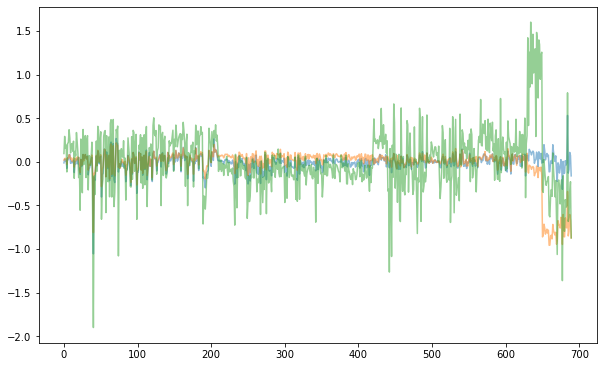

In [243]:
plt.plot(gamma_mode18[600][:690], alpha=0.5)
plt.plot(gamma_mode20[600][:690], alpha=0.5)
plt.plot(gamma_mode15[600][:690], alpha=0.5)
# plt.plot(gamma_mode16[722][:690], alpha=0.5)

In [244]:
B = mode_20['B']
cutoff = 600
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [245]:
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_20/a_prime_all.npy"
a_prime_all_mode20 = np.load(abFile, allow_pickle=True)
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_20/a_all.npy"
a_all_mode20 = np.load(abFile, allow_pickle=True)

In [254]:
from cvxopt import matrix, solvers
A_B = mode_20
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
# additional_constraint = np.diag([-1]*n)
# additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
additional_constraint = a_prime_all_mode20
# additional_constraint = -a_all_mode18
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-10, -50]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  1.2881e+00  2.6033e+03  7e+04  3e+01  9e+04
 1:  4.2743e+01 -1.7341e+04  4e+04  2e+01  5e+04
 2:  1.0048e+02 -4.0736e+03  5e+03  2e+00  6e+03
 3:  6.0374e+01 -9.2565e+02  1e+03  5e-01  1e+03
 4:  5.3607e+01 -3.2300e+01  9e+01  4e-02  1e+02
 5:  5.2699e+01  4.4668e+01  8e+00  3e-03  9e+00
 6:  5.2401e+01  5.1287e+01  1e+00  3e-04  8e-01
 7:  5.2726e+01  5.1662e+01  1e+00  2e-04  5e-01
 8:  5.2378e+01  5.2285e+01  9e-02  1e-06  4e-03
 9:  5.2353e+01  5.2351e+01  1e-03  2e-08  5e-05
10:  5.2352e+01  5.2352e+01  1e-05  2e-10  5e-07
11:  5.2352e+01  5.2352e+01  1e-07  2e-12  5e-09
Optimal solution found.


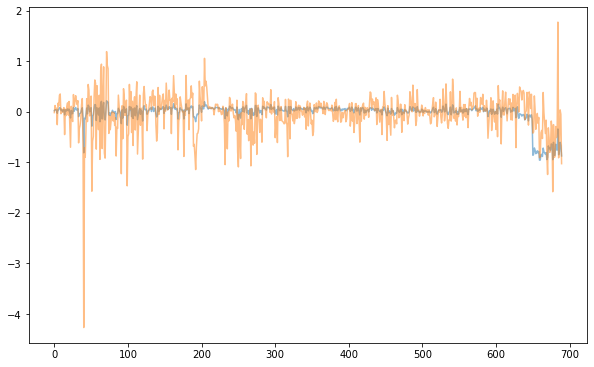

In [255]:
plt.plot(gamma_mode20[600][:690], alpha=0.5)
plt.plot(x, alpha=0.5)

In [256]:
# z score
A_B = mode_20
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_mode20[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.3832367889441166 7.229420212019691 10.000000000001812 -50.00000202942445


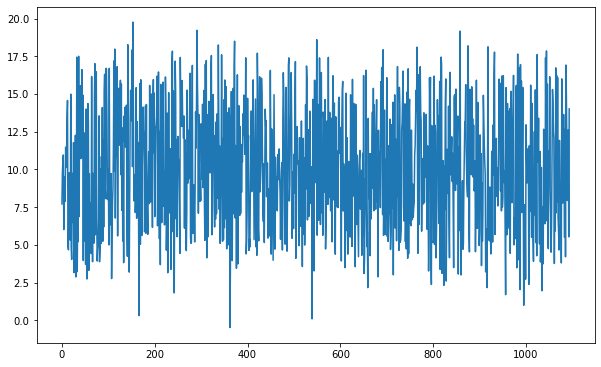

In [257]:
e_decoys = a_all_mode20.dot(x)
plt.plot(e_decoys)

In [ ]:
e_decoys = a_all_mode20.dot(x)
plt.plot(e_decoys)

In [258]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/mode20_decoy50.dat", x)

## with four body term

In [142]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_19/gamma/"
mode_19 = get_A_B(pre, n=2022)

In [143]:
A_B = mode_19
cutoff_range=list(range(522, 2122, 100)) 
gamma_mode19 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [144]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode19[722]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.7952686649207632 1.7255169560688408 3.097766522019847 -4.1639380745500665e-14


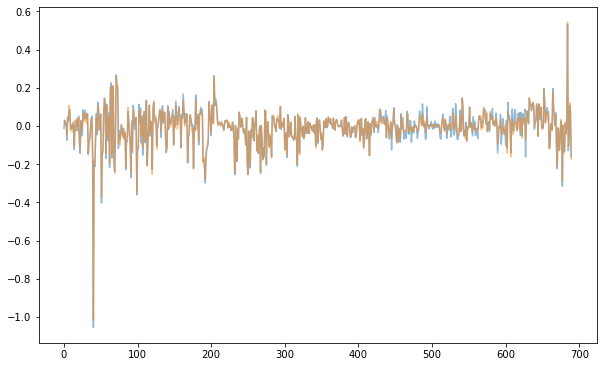

In [146]:
plt.plot(gamma_mode18[600][:690], alpha=0.5)
plt.plot(gamma_mode19[722][:690], alpha=0.5)
# plt.plot(gamma_mode16[722][:690], alpha=0.5)

In [154]:
# z score
A_B = mode_19
B = A_B["B"][:690,:690]
A = A_B["A"][:690]
A_prime = A_B["A_prime"][:690]
# x = gamma_mode16[722]
# x = gamma_mode18[600]
x = gamma_mode19[722][:690]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.555612371954856 1.480976308964884 2.303825068797811 -0.31545550522174765


## multi swapping

In [127]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_18/gamma/"
mode_18 = get_A_B(pre, n=690)

In [128]:
A_B = mode_18
cutoff_range=list(range(400, 700, 20)) 
gamma_mode18 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [200]:
# z score
A_B = mode_18
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode18[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.6023974535297358 1.6017464202657083 2.566634385034141 2.4313884239290928e-14


In [136]:
A_B = mode_15
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode18[600]
# x = gamma_mode17[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

3.3666541002619708 1.6024120120471539 5.394766970667585 2.879431372056806


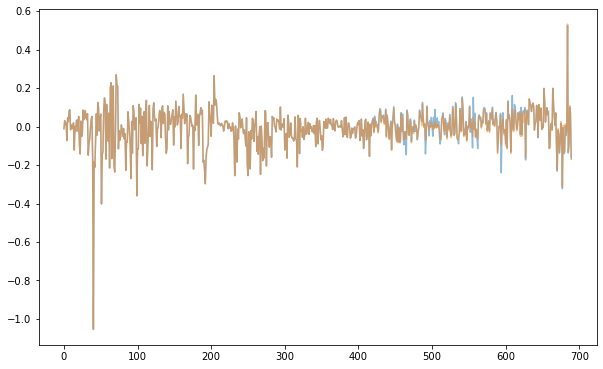

In [180]:
plt.plot(gamma_mode18[680][:690], alpha=0.5)
plt.plot(gamma_mode18[600][:690], alpha=0.5)

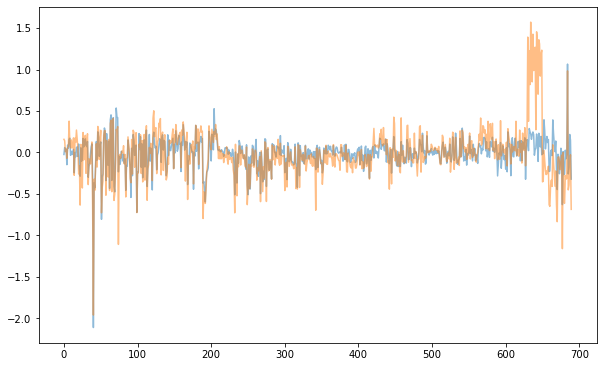

In [206]:
plt.plot(2*gamma_mode18[600][:690], alpha=0.5)
# plt.plot(2*gamma_mode17[600][:690], alpha=0.5)
plt.plot(gamma_mode16[722][:690], alpha=0.5)

In [156]:
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_18/a_prime_all.npy"
a_prime_all_mode18 = np.load(abFile, allow_pickle=True)
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_18/a_all.npy"
a_all_mode18 = np.load(abFile, allow_pickle=True)

In [181]:
B = mode_18['B']
cutoff = 600
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [207]:
from cvxopt import matrix, solvers
A_B = mode_18
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
# additional_constraint = np.diag([-1]*n)
# additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
additional_constraint = a_prime_all_mode18
# additional_constraint = -a_all_mode18
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-2.57, -0]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  7.6950e-02  9.0717e+00  4e+03  5e+01  9e+04
 1:  1.3418e+01 -8.4706e+02  1e+03  1e+01  2e+04
 2:  8.0611e+00 -1.4474e+02  2e+02  1e+00  3e+03
 3:  4.3865e+00 -3.4904e+01  4e+01  3e-01  6e+02
 4:  2.9660e+00 -1.0867e+01  1e+01  1e-01  2e+02
 5:  2.6303e+00  1.0500e+00  2e+00  1e-02  2e+01
 6:  2.5980e+00  2.2898e+00  3e-01  2e-03  3e+00
 7:  2.5865e+00  2.5246e+00  6e-02  3e-04  6e-01
 8:  2.5864e+00  2.5471e+00  4e-02  2e-04  3e-01
 9:  2.5843e+00  2.5769e+00  7e-03  3e-05  5e-02
10:  2.5841e+00  2.5839e+00  2e-04  2e-07  5e-04
11:  2.5841e+00  2.5841e+00  2e-06  2e-09  5e-06
12:  2.5841e+00  2.5841e+00  2e-08  2e-11  5e-08
Optimal solution found.


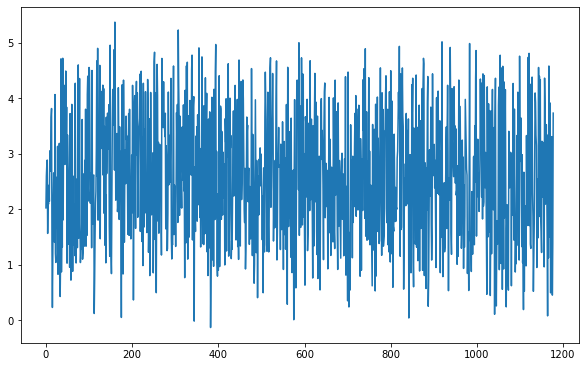

In [208]:
e_decoys = a_all_mode18.dot(x)
plt.plot(e_decoys)

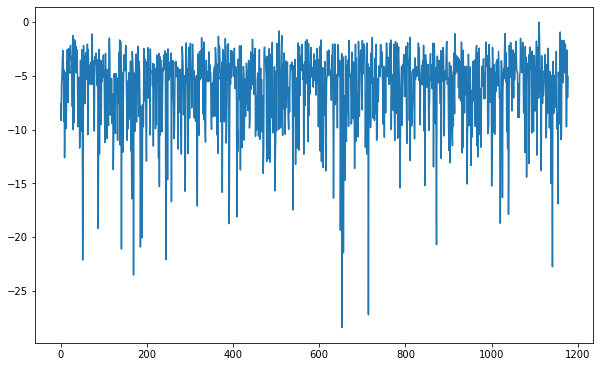

In [211]:
e_decoys = a_prime_all_mode18.dot(x)
plt.plot(e_decoys)

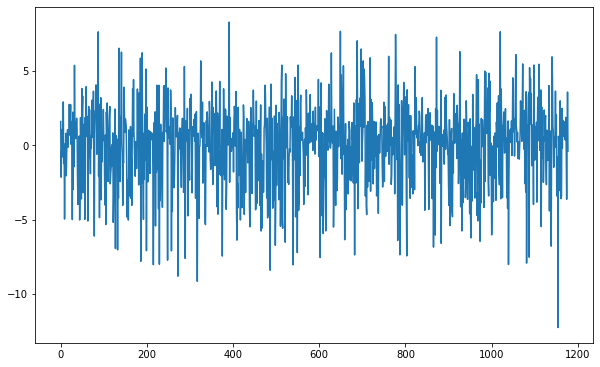

In [213]:
e_decoys = a_prime_all_mode18.dot(gamma_mode18[600])
plt.plot(e_decoys)

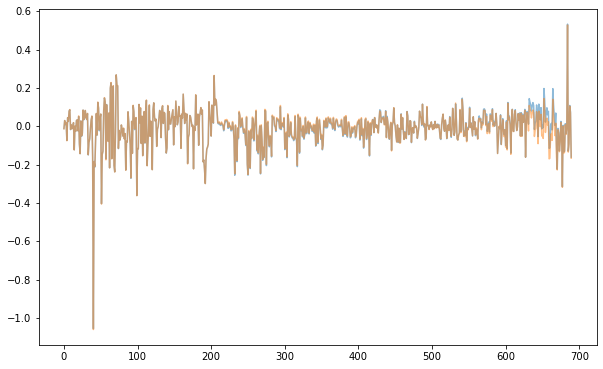

In [209]:
plt.plot(gamma_mode18[600][:690], alpha=0.5)
plt.plot(x, alpha=0.5)

In [214]:
# z score
A_B = mode_18
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_mode18[600]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

1.59911593104235 1.6071380130330029 2.5700000000248227 -6.116724433643385


In [215]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/mode18.dat", 2*x)

## single swap

In [95]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_17/gamma/"
mode_17 = get_A_B(pre, n=690)

In [96]:
A_B = mode_17
cutoff_range=list(range(400, 700, 20)) 
gamma_mode17 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

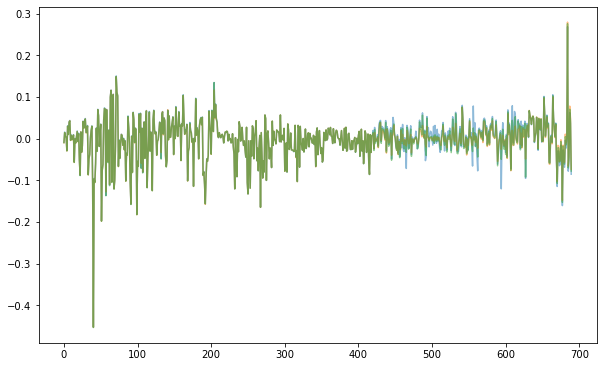

In [109]:
plt.plot(gamma_mode17[680][:690], alpha=0.5)
plt.plot(gamma_mode17[520][:690], alpha=0.5)
plt.plot(gamma_mode17[600][:690], alpha=0.5)

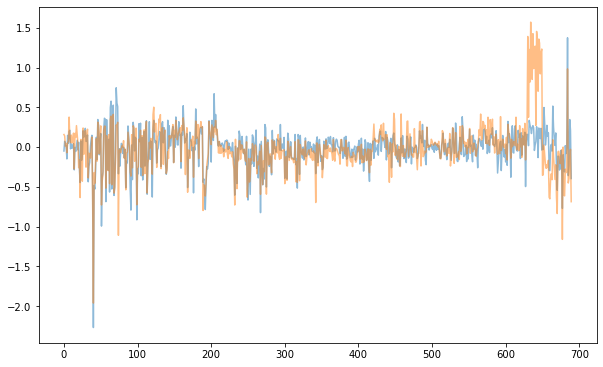

In [107]:
plt.plot(5* gamma_mode17[620][:690], alpha=0.5)
plt.plot(gamma_mode16[722][:690], alpha=0.5)
# plt.plot(gamma_mode15[520][:690])

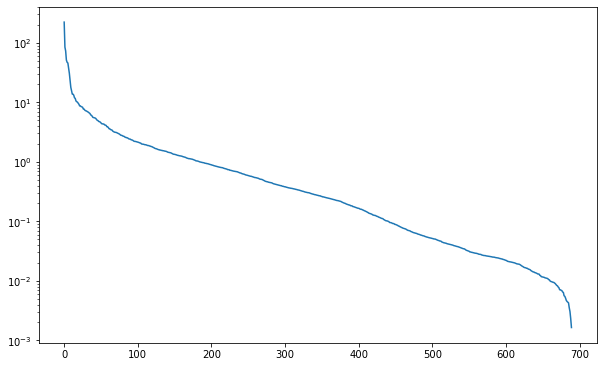

In [108]:
B = A_B['B']
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")

In [105]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode17[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.7951810888197598 0.7940091516131166 0.6313810617125718 3.0531133177191805e-15


In [106]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode17[680]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.795753389886715 0.7957250352781431 0.6332008942403082 2.7255975254547593e-14


In [111]:
B = mode_17['B']
cutoff = 600
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [124]:
from cvxopt import matrix, solvers
A_B = mode_17
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))

n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n)]), (2,n))
h = matrix([-3, -0], (2, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  8.2154e-01  6.0156e+00  2e+00  2e+00  1e-13
 1:  6.0180e+00  1.2486e+01  3e+00  7e-01  5e-14
 2:  1.7155e+01  1.1906e+01  5e+00  9e-15  2e-13
 3:  1.4642e+01  1.3917e+01  7e-01  1e-14  2e-13
 4:  1.4293e+01  1.4189e+01  1e-01  3e-15  6e-13
 5:  1.4236e+01  1.4222e+01  1e-02  2e-15  1e-12
 6:  1.4227e+01  1.4225e+01  1e-03  1e-15  3e-12
 7:  1.4225e+01  1.4225e+01  3e-05  3e-15  7e-12
 8:  1.4225e+01  1.4225e+01  3e-07  2e-15  2e-11
Optimal solution found.


In [125]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
# x = gamma_mode17[680]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

0.7955802160094607 3.7708328340043202 3.000000000612724 -0.00017400906743603173


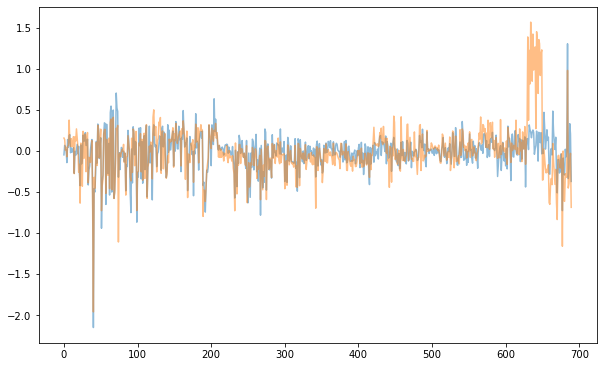

In [126]:
plt.plot(x, alpha=0.5)
# plt.plot(gamma_mode17[620][:690], alpha=0.5)
plt.plot(gamma_mode16[722][:690], alpha=0.5)
# plt.plot(gamma_mode15[520][:690])

In [84]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_16/gamma/"
mode_16 = get_A_B(pre, n=2022)

In [85]:
abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_16/a_prime_all.npy"
a_prime_all_mode16 = np.load(abFile, allow_pickle=True)

In [86]:
A_B = mode_16
cutoff_range=list(range(522, 2122, 100)) 
gamma_mode16 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [87]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
x = gamma_mode16[722]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

5.006197747326388 4.816455992909468 24.11213114180006 2.372545519421787e-13


In [88]:
B = mode_16['B']
cutoff = 722
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [89]:
from cvxopt import matrix, solvers
A_B = mode_16
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
# additional_constraint = np.diag([-1]*n)
# additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
additional_constraint = a_prime_all_mode16
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-24, -0]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  3.5573e+01  1.0641e+02  2e+04  9e+00  2e+05
 1:  5.7300e+01 -1.9653e+03  2e+03  1e+00  2e+04
 2:  3.7141e+01 -3.5934e+02  4e+02  2e-01  4e+03
 3:  2.9939e+01 -3.9933e+01  7e+01  3e-02  6e+02
 4:  2.8326e+01  8.7680e+00  2e+01  9e-03  2e+02
 5:  2.7709e+01  2.1487e+01  6e+00  3e-03  5e+01
 6:  2.7232e+01  2.4614e+01  3e+00  1e-03  2e+01
 7:  2.7092e+01  2.4531e+01  3e+00  9e-04  1e+01
 8:  2.6691e+01  2.5796e+01  9e-01  4e-04  6e+00
 9:  2.6484e+01  2.5529e+01  1e+00  3e-04  5e+00
10:  2.6186e+01  2.5126e+01  1e+00  2e-04  4e+00
11:  2.5842e+01  2.5154e+01  7e-01  8e-05  1e+00
12:  2.5796e+01  2.5768e+01  3e-02  4e-06  7e-02
13:  2.5795e+01  2.5795e+01  3e-04  4e-08  7e-04
14:  2.5795e+01  2.5795e+01  3e-06  4e-10  7e-06
15:  2.5795e+01  2.5795e+01  3e-08  4e-12  7e-08
Optimal solution found.


In [93]:
toLocation = "/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder"
np.savetxt(f"{toLocation}/complete_cutoff722_contact_part_all_prime_oct14.dat", x[:690])
np.savetxt(f"{toLocation}/complete_cutoff722_fourBody_part_all_prime_oct14.dat", -x[690:])
np.savetxt(f"{toLocation}/complete_cutoff722_all_part_all_prime_oct14.dat", x)

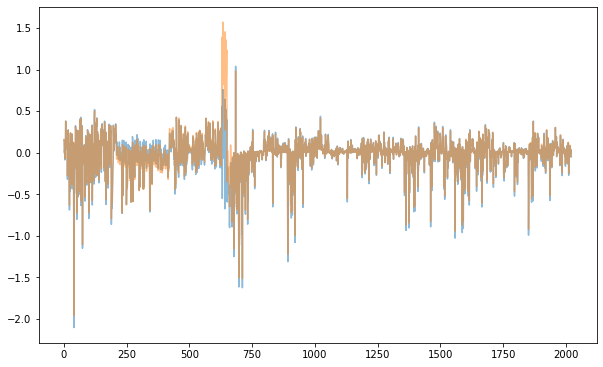

In [92]:
plt.plot(x, alpha=0.5)
plt.plot(gamma_mode16[722], alpha=0.5)

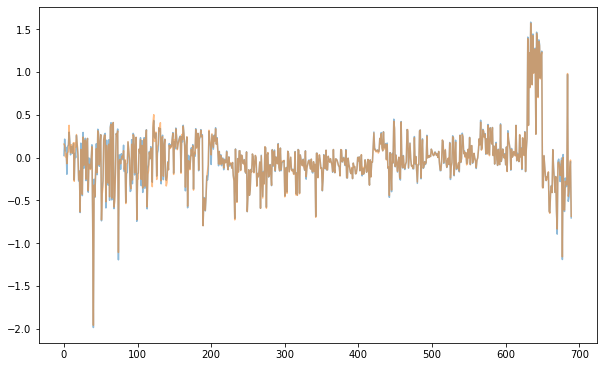

In [90]:
plt.plot(gamma_mode15[520][:690], alpha=0.5)
plt.plot(gamma_mode16[722][:690], alpha=0.5)

In [269]:
data = pd.read_csv("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/z_scores.csv")

In [271]:
data.sort_values("Z")

,Unnamed: 0,Protein,E_native,E_decoy,E_diff,E_std,Z
73,73,2qfi_A,-28.017533,-2.461019e+01,3.407342,3.637535,0.936717
290,290,2lck_A,-5.009790,-8.322852e-09,5.009790,4.431393,1.130523
714,714,2gfp_A,-102.543241,-9.575537e+01,6.787866,5.991653,1.132887
451,451,6vja_D,-26.735181,-2.346513e+01,3.270056,2.781441,1.175670
583,583,2mgy_A,-38.204362,-3.444577e+01,3.758590,2.986710,1.258438
...,...,...,...,...,...,...,...
266,266,3rce_A,-145.930551,-1.015969e+02,44.333637,5.645482,7.852940
191,191,6kzo_A,-224.012710,-1.599975e+02,64.015227,8.140501,7.863794
167,167,5xti_j,-194.259449,-1.380684e+02,56.191035,6.829266,8.227976
51,51,6kzp_A,-240.179971,-1.709118e+02,69.268162,8.151418,8.497682


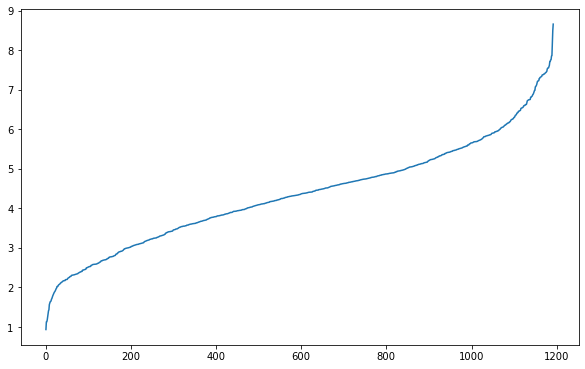

In [274]:
plt.plot(data.sort_values("Z").reset_index()["Z"])

## mode 15 repeats mode 9 (contact term only), but with bug-fixed

In [13]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/gamma/"
mode_15 = get_A_B(pre, n=690)

In [14]:
A_B = mode_15
cutoff_range=list(range(400, 700, 20)) 
gamma_mode15 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

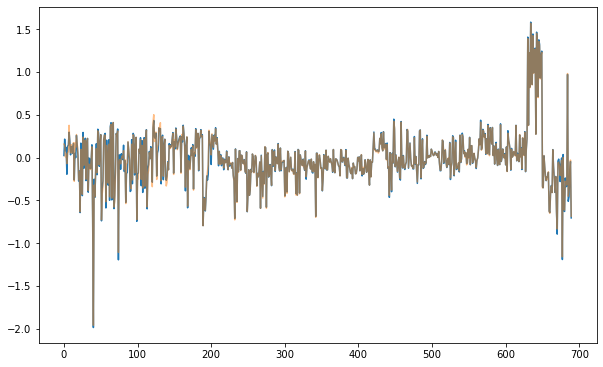

In [28]:
plt.plot(gamma_mode15[520][:690])
plt.plot(gamma_mode16[722][:690], alpha=0.5)
# plt.plot(gamma_mode15[520][:690])

In [22]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722]
x = gamma_mode15[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.640464057648172 4.608435332275099 21.38527852141851 5.906386491005833e-14


In [23]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
x = gamma_mode16[722][:690]
# x = gamma_mode15[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.5289848296963395 4.406746924004438 19.95808996712711 1.049871138799504


In [30]:
B = mode_15['B']
cutoff = 520
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [75]:
from cvxopt import matrix, solvers
A_B = mode_15
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
additional_constraint = np.diag([-1]*n)
additional_constraint = A_B_6nq0_A['A_prime'].reshape(1,n)
additional_constraint = a_prime_all
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
# h = matrix([-21, -0]+[15]*n, (2+n, 1), 'd')
# G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+1,n))
# h = matrix([-21, -0]+[-0], (2+1, 1), 'd')
n_additional_constraint = additional_constraint.shape[0]
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n_additional_constraint,n))
h = matrix([-21, -0]+[-0]*n_additional_constraint, (2+n_additional_constraint, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  2.6911e+01  1.1442e+02  2e+04  1e+01  2e+05
 1:  5.8358e+01 -2.1890e+03  3e+03  2e+00  2e+04
 2:  3.4914e+01 -3.8051e+02  4e+02  2e-01  3e+03
 3:  2.7041e+01 -5.1661e+01  8e+01  4e-02  6e+02
 4:  2.5327e+01  5.3632e+00  2e+01  1e-02  1e+02
 5:  2.4482e+01  1.8007e+01  6e+00  3e-03  4e+01
 6:  2.4024e+01  2.0099e+01  4e+00  2e-03  2e+01
 7:  2.3816e+01  2.0166e+01  4e+00  1e-03  2e+01
 8:  2.3373e+01  2.1974e+01  1e+00  5e-04  7e+00
 9:  2.3148e+01  2.1622e+01  2e+00  4e-04  5e+00
10:  2.2864e+01  2.1785e+01  1e+00  2e-04  3e+00
11:  2.2550e+01  2.2311e+01  2e-01  5e-05  7e-01
12:  2.2519e+01  2.2515e+01  4e-03  4e-07  6e-03
13:  2.2519e+01  2.2519e+01  4e-05  4e-09  6e-05
14:  2.2519e+01  2.2519e+01  4e-07  4e-11  6e-07
15:  2.2519e+01  2.2519e+01  4e-09  5e-13  6e-09
Optimal solution found.


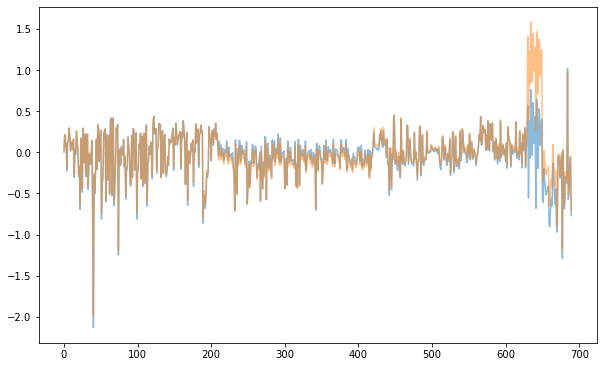

In [76]:
plt.plot(x, alpha=0.5)
plt.plot(gamma_mode15[520][:690], alpha=0.5)

In [73]:
# import glob
# ab_list = glob.glob("/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/A_B_dic/*.npy")
# a_prime_all = np.zeros((len(ab_list), 690))
# for abFile in ab_list:
#     A_B_one = np.load(abFile, allow_pickle=True).item()
#     a_prime_all = A_B_one["A_prime"]

abFile = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_15/a_prime_all.npy"
a_prime_all = np.load(abFile, allow_pickle=True)

In [74]:
a_prime_all

array([[1.87679006, 1.1369308 , 1.0812917 , ..., 1.23074547, 2.02222888,
        4.99261131],
       [4.85276668, 1.58350866, 1.40217948, ..., 1.84914302, 2.70250495,
        8.75344392],
       [0.9882021 , 0.60782271, 0.40400915, ..., 1.40091433, 1.79943992,
        3.7836284 ],
       ...,
       [0.39029175, 0.2278609 , 0.14997577, ..., 0.15530463, 0.06551744,
        0.62402178],
       [1.38424566, 1.25354991, 1.09497621, ..., 0.87404378, 1.34934104,
        2.70164878],
       [1.47953867, 0.79072309, 0.3829428 , ..., 1.34111058, 1.94186277,
        3.80409148]])

In [77]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
# x = gamma_mode16[722][:690]
# x = gamma_mode15[520]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.44948869404758 4.719643411633881 21.000000000001105 -66.08984543497455


In [78]:
np.savetxt("/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder/new_mode15_all_prime.dat", x)

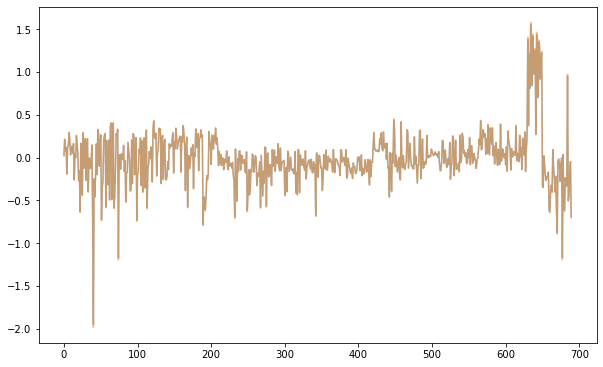

In [44]:
plt.plot(x, alpha=0.5)
plt.plot(gamma_mode15[520][:690], alpha=0.5)

In [4]:
pre = "/Users/weilu/Research/server/oct_2020/curated_single_chain_optimization/optimization_msa_submode_16/gamma/"
mode_16 = get_A_B(pre, n=2022)

In [5]:
A_B = mode_16
cutoff_range=list(range(522, 2122, 100)) 
gamma_mode16 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [8]:
# z score
B = A_B["B"]
A = A_B["A"]
A_prime = A_B["A_prime"]
x = gamma_mode16[722]
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

5.006197747326388 4.816455992909468 24.11213114180006 2.372545519421787e-13


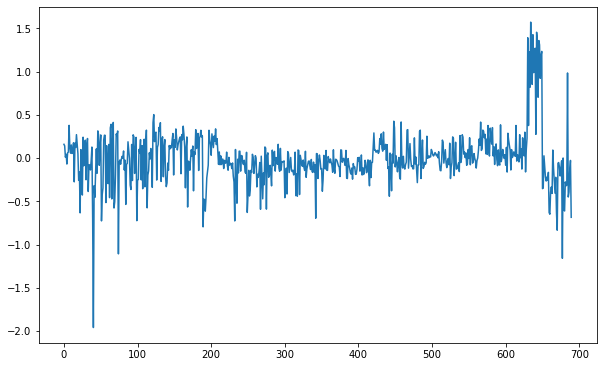

In [6]:
plt.plot(gamma_mode16[722][:690])

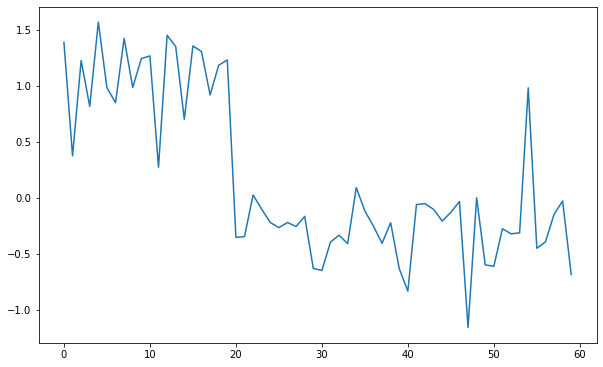

In [9]:
plt.plot(gamma_mode16[722][630:690])

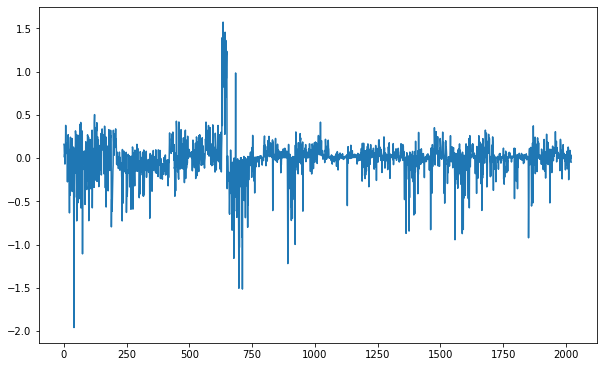

In [7]:
plt.plot(gamma_mode16[722])

In [10]:
toLocation = "/Users/weilu/Research/server/oct_2020/membrane_protein_structure_prediction/gamma_folder"
np.savetxt(f"{toLocation}/complete_cutoff722_contact_part_oct11.dat", x[:690])
np.savetxt(f"{toLocation}/complete_cutoff722_fourBody_part_oct11.dat", -x[690:])
np.savetxt(f"{toLocation}/complete_cutoff722_all_part_oct11.dat", x)

In [12]:
A_B["A_prime"].dot(gamma_mode16[722])

2.372545519421787e-13

In [ ]:
A_B = mode_16
B = A_B['B']
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")

In [24]:
pre = "/Users/weilu/Research/server/sep_2020//curated_single_chain_optimization/optimization_msa_submode_12/gamma/"
six_letter_submode12 = get_A_B(pre, n=690)
cutoff_range=list(range(190, 700, 10)) 
A_B = six_letter_submode12
gamma_six_letter_submode12 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [35]:
np.savetxt("/Users/weilu/Research/server/sep_2020/membrane_protein_structure_prediction/gamma_folder/contact_submode12_cutoff550.dat", gamma_six_letter_submode12[550])

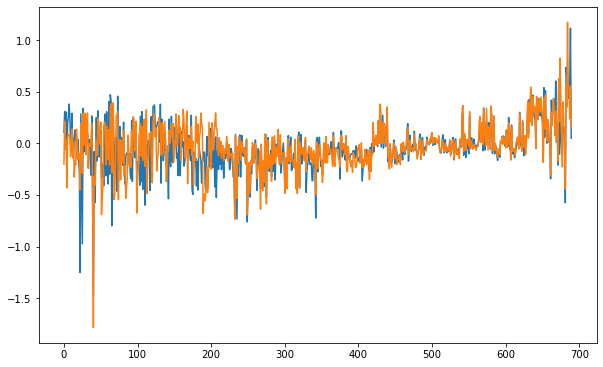

In [29]:
plt.plot(gamma_six_letter_submode12[450])
plt.plot(gamma_six_letter_submode9[450])

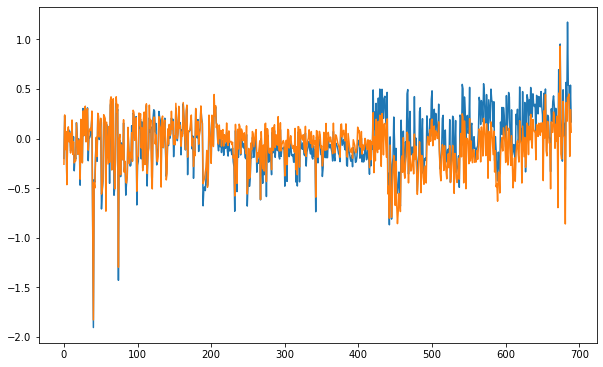

In [34]:

plt.plot(gamma_six_letter_submode9[550])
plt.plot(gamma_six_letter_mode9[550])

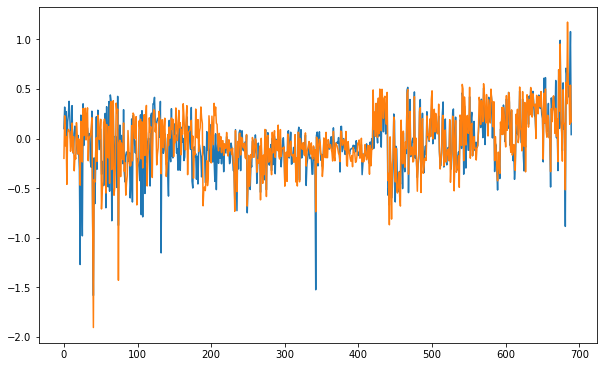

In [30]:
plt.plot(gamma_six_letter_submode12[550])
plt.plot(gamma_six_letter_submode9[550])

In [39]:
pre = "/Users/weilu/Research/server/sep_2020//curated_single_chain_optimization/optimization_msa_submode_9/gamma/"
six_letter_submode9 = get_A_B(pre, n=690)
cutoff_range=list(range(390, 700, 10)) 
A_B = six_letter_submode9
gamma_six_letter_submode9 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [ ]:
pre = "/Users/weilu/Research/server/sep_2020//curated_single_chain_optimization/optimization_msa_mode_9/gamma/"
six_letter_mode9 = get_A_B(pre, n=690)


In [6]:
cutoff_range=list(range(190, 700, 10)) 
A_B = six_letter_mode9
gamma_six_letter_mode9 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

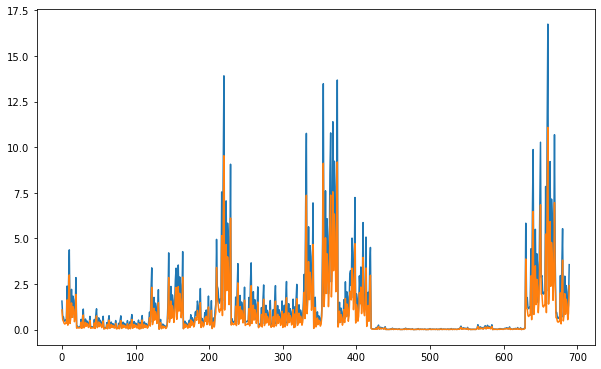

In [23]:
plt.plot(six_letter_submode9['A_prime'])
plt.plot(six_letter_mode9['A_prime'])

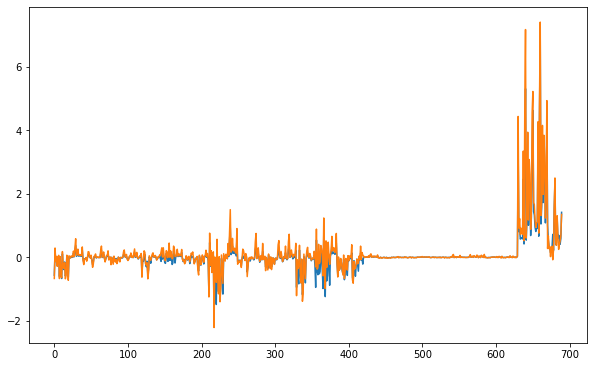

In [22]:
plt.plot(six_letter_mode9['A'])
plt.plot(six_letter_submode9['A'])

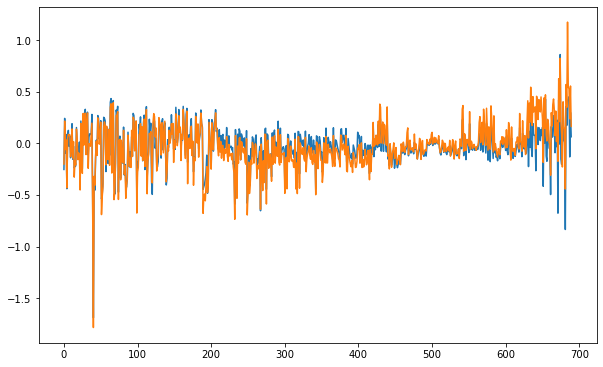

In [13]:
plt.plot(gamma_six_letter_mode9[450])
plt.plot(gamma_six_letter_submode9[450])

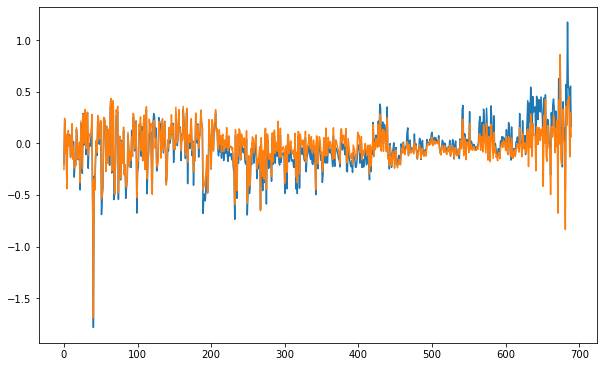

In [14]:
plt.plot(gamma_six_letter_submode9[450])
plt.plot(gamma_six_letter_mode9[450])


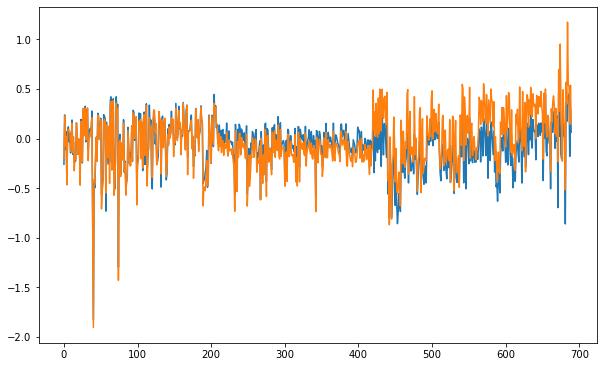

In [7]:
plt.plot(gamma_six_letter_mode9[550])
plt.plot(gamma_six_letter_submode9[550])

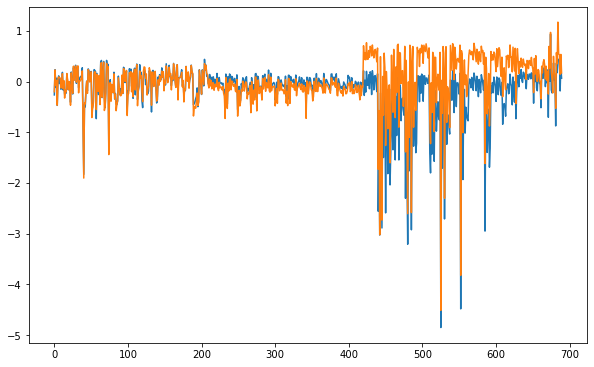

In [8]:
plt.plot(gamma_six_letter_mode9[690])
plt.plot(gamma_six_letter_submode9[690])

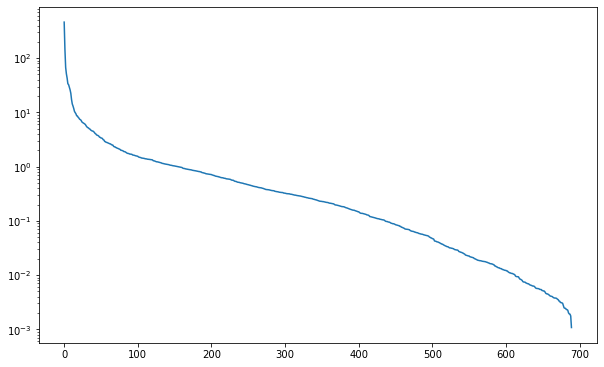

In [30]:
B = A_B['B']
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")

In [31]:
gamma = gamma_six_letter_mode9[680]
A_B['A'].dot(gamma)

16.94385165767069

In [32]:
A_B['A_prime'].dot(gamma)

-3.164135620181696e-15

In [33]:
np.sqrt(gamma.dot(A_B['B']).dot(gamma))

4.114337810892066

In [34]:
A_B['A'].dot(gamma) / np.sqrt(gamma.dot(A_B['B']).dot(gamma))

4.118245131164119

In [15]:
gamma = gamma_six_letter_mode9[550]
A_B['A'].dot(gamma) / np.sqrt(gamma.dot(A_B['B']).dot(gamma))

4.062342945633896

In [16]:
gamma = gamma_six_letter_mode9[450]
A_B['A'].dot(gamma) / np.sqrt(gamma.dot(A_B['B']).dot(gamma))

4.012557519208387

In [17]:
A_B = six_letter_submode9
gamma = gamma_six_letter_submode9[450]
A_B['A'].dot(gamma) / np.sqrt(gamma.dot(A_B['B']).dot(gamma))

6.4845799398085475

In [19]:
A_B = six_letter_submode9
gamma = gamma_six_letter_mode9[450]
A_B['A'].dot(gamma) / np.sqrt(gamma.dot(A_B['B']).dot(gamma))

5.374919819739599

In [18]:
A_B = six_letter_mode9
gamma = gamma_six_letter_submode9[450]
A_B['A'].dot(gamma) / np.sqrt(gamma.dot(A_B['B']).dot(gamma))

3.345460992957597

In [47]:
np.savetxt("/Users/weilu/Research/server/sep_2020/membrane_protein_structure_prediction/gamma_folder/contact_cutoff550.dat", gamma_six_letter_mode9[550])

In [39]:
np.savetxt("/Users/weilu/Research/server/sep_2020/membrane_protein_structure_prediction/gamma_folder/contact_cutoff450.dat", gamma_six_letter_mode9[450])

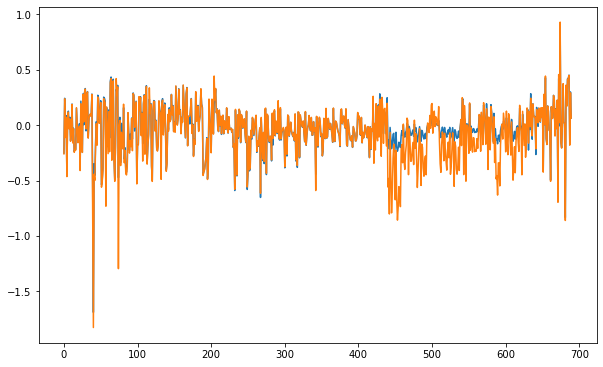

In [37]:
plt.plot(gamma_six_letter_mode9[450])
plt.plot(gamma_six_letter_mode9[550])

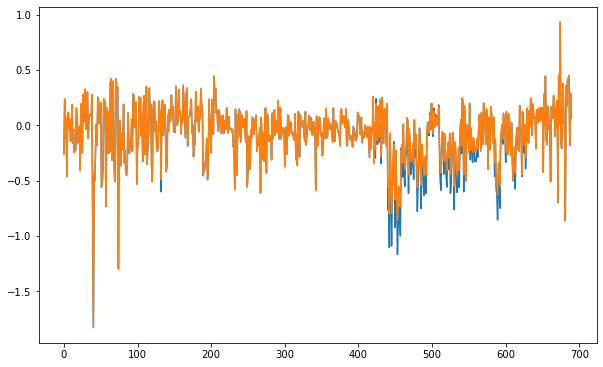

In [36]:
plt.plot(gamma_six_letter_mode9[580])
plt.plot(gamma_six_letter_mode9[550])

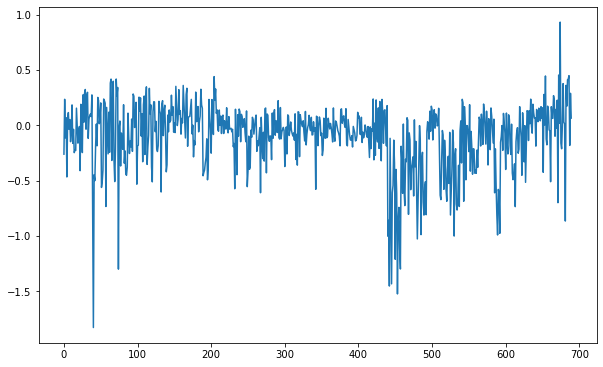

In [38]:
plt.plot(gamma_six_letter_mode9[600])

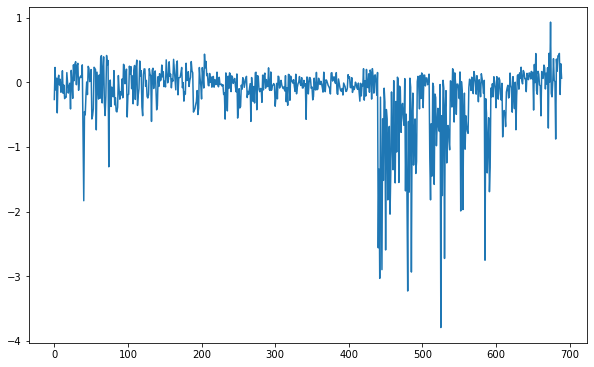

In [35]:
plt.plot(gamma_six_letter_mode9[680])

In [46]:
np.savetxt("/Users/weilu/Research/server/sep_2020/membrane_protein_structure_prediction/gamma_folder/contact_cutoff680.dat", gamma_six_letter_mode9[680])

In [7]:
a = pd.read_csv("/Users/weilu/Research/server/sep_2020/curated_single_chain_optimization/optimization_msa_mode_7/info_folder/1ap9_A.csv", index_col=0)

In [11]:
b = pd.read_csv("/Users/weilu/Research/server/sep_2020/curated_single_chain_optimization/optimization_msa_mode_9/info_folder/1ap9_A_contact.csv", index_col=0)

In [16]:
a = a.assign(interactionTerm="contact")

In [17]:
pd.concat([a,b], sort=False)

,phi,res1,res1_2,res2,res2_2,direction,res1_name,res1_2_name,res2_name,res2_2_name,interaction_index,interactionTerm,Type
0,1.000000,0,4.0,148,152.0,parallel,PRO,TRP,ASN,LEU,486,contact,NaN
1,0.045489,1,5.0,147,151.0,parallel,GLU,LEU,LEU,THR,521,contact,NaN
2,1.000000,4,8.0,151,155.0,parallel,TRP,GLY,THR,MET,309,contact,NaN
3,0.898892,5,9.0,38,42.0,parallel,LEU,THR,TYR,LEU,527,contact,NaN
4,1.000000,5,9.0,42,38.0,anti,LEU,THR,LEU,TYR,1193,contact,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,0.000343,167,NaN,1,NaN,NaN,LEU,NaN,NaN,NaN,660,NaN,Burial
1227,0.000014,168,NaN,0,NaN,NaN,ILE,NaN,NaN,NaN,639,NaN,Burial
1228,0.999983,168,NaN,1,NaN,NaN,ILE,NaN,NaN,NaN,659,NaN,Burial
1229,0.993917,169,NaN,0,NaN,NaN,LEU,NaN,NaN,NaN,640,NaN,Burial


In [35]:
a = np.load("/Users/weilu/Research/server/sep_2020//curated_single_chain_optimization/optimization_msa_mode_10/phis/6uus_R.npy")

In [46]:
b = np.load("/Users/weilu/Research/server/sep_2020//curated_single_chain_optimization/optimization_msa_mode_10/A_B_dic/4bgn_A.npy", allow_pickle=True).item()

In [12]:
# mode 11 is the same as 10, just with filtered pdb list.(protein with enough MSA information)
pre = "/Users/weilu/Research/server/sep_2020//curated_single_chain_optimization/optimization_msa_mode_11/gamma/"
six_letter_mode11 = get_A_B(pre, n=2022)


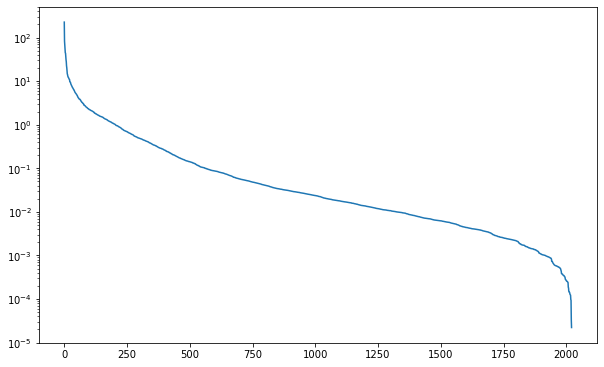

In [13]:
A_B = six_letter_mode11
B = A_B['B']
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")

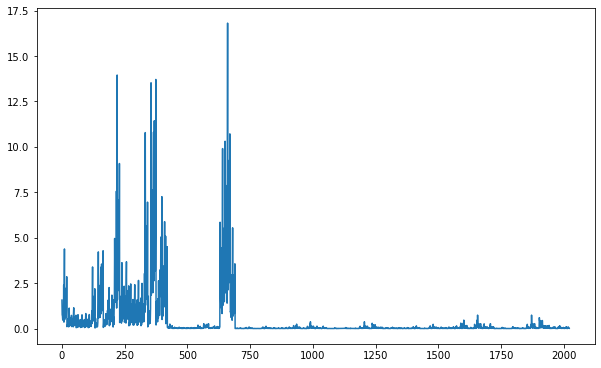

In [14]:
plt.plot(six_letter_mode11['A_prime'])

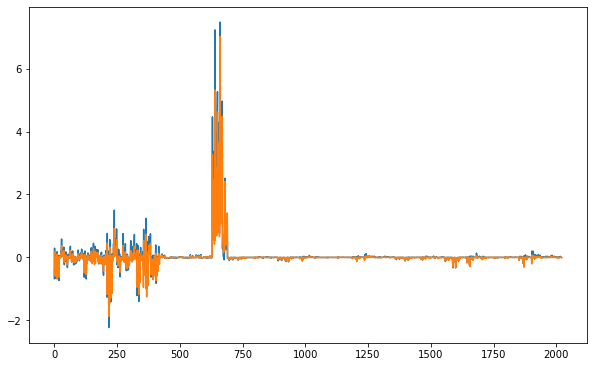

In [16]:
plt.plot(six_letter_mode11['A'])
plt.plot(six_letter_mode10['A'])

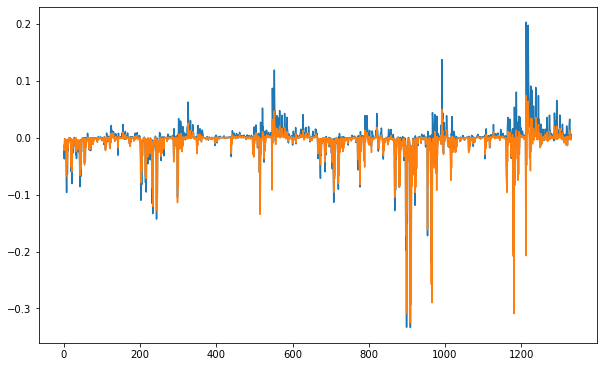

In [20]:
plt.plot(six_letter_mode11['A'][690:])
plt.plot(six_letter_mode10['A'][690:])

In [6]:
pre = "/Users/weilu/Research/server/sep_2020//curated_single_chain_optimization/optimization_msa_mode_10/gamma/"
six_letter_mode10 = get_A_B(pre, n=2022)



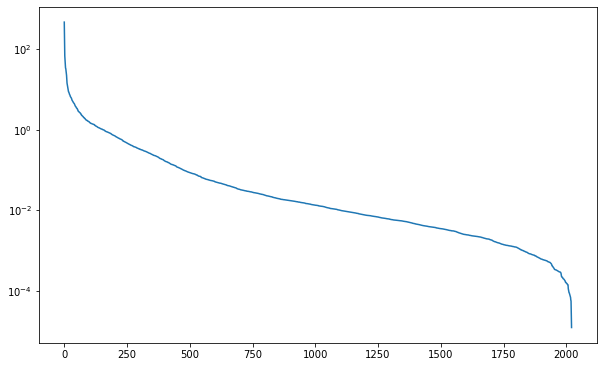

In [9]:
A_B = six_letter_mode10
B = A_B['B']
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
plt.plot(lamb)
plt.yscale("log")

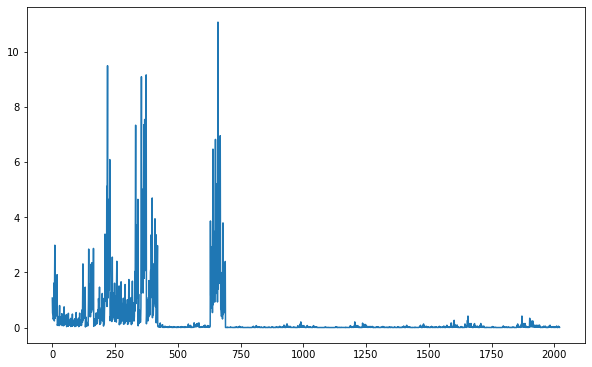

In [10]:
plt.plot(A_B['A_prime'])

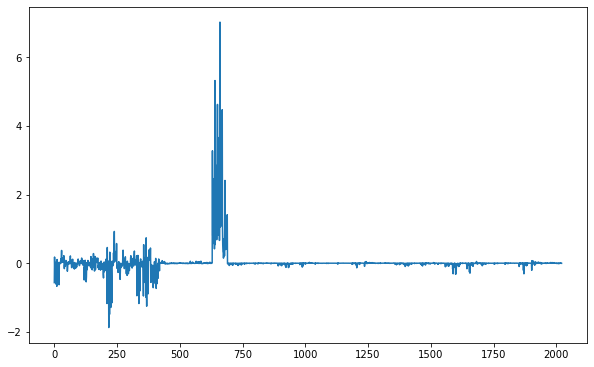

In [11]:
plt.plot(A_B['A'])

In [53]:
len(A_B['A'])

2022

In [31]:
A_B = six_letter_mode11
keep = 690
cutoff_range=list(range(522, 690, 30)) 
test_mode11 = get_gamma(A_B['A'][:keep], A_B['B'][:keep,:keep], A_B['A_prime'][:keep], c=-0, cutoff_range=cutoff_range)

# They are identical, which should be.

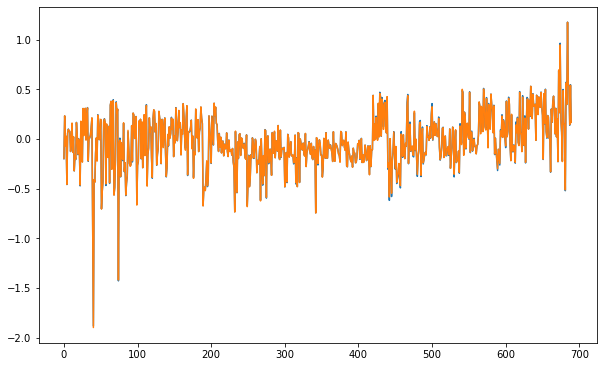

In [46]:
plt.plot(test_mode11[522])
plt.plot(gamma_six_letter_submode9[520])

# When putting contact term and four body term together, the new cutoff set to 722 will produce about the same result for the contact part.

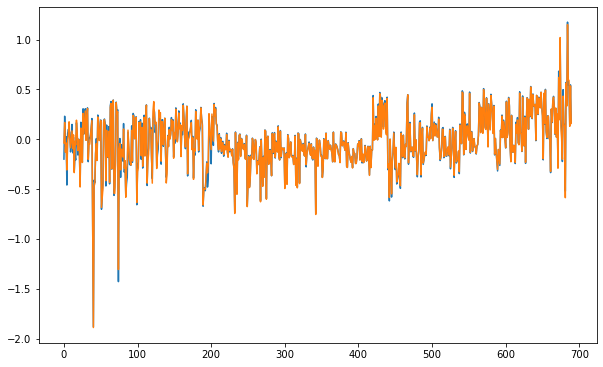

In [52]:
plt.plot(test_mode11[522])
plt.plot(gamma_six_letter_mode11[722][:690])

# the four body part also looks reasonable.

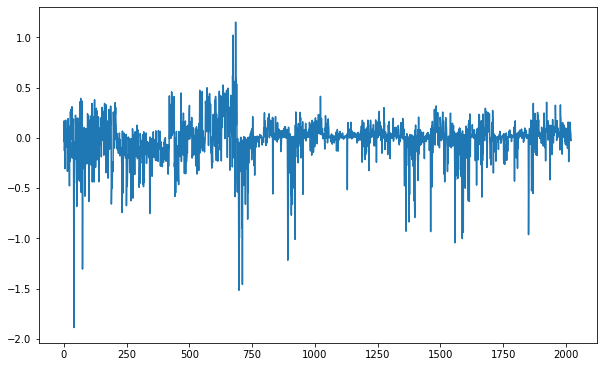

In [53]:
plt.plot(gamma_six_letter_mode11[722])

In [59]:
B = six_letter_mode11['B']
cutoff = 722
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [71]:
from cvxopt import matrix, solvers
A_B = six_letter_mode11
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
additional_constraint = np.diag([-1]*n)
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
h = matrix([-45, -0]+[15]*n, (2+n, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  1.7882e+04 -8.5722e+04  1e+05  2e-16  1e+03
 1:  1.5337e+04  3.9541e+03  1e+04  3e-16  2e+02
 2:  1.0497e+04  6.6204e+03  4e+03  3e-16  9e+01
 3:  7.5406e+02 -1.2122e+04  1e+04  1e-15  9e+00
 4:  5.0663e+01 -6.8374e+02  7e+02  2e-16  3e-13
 5:  4.4588e+01  3.6735e+01  8e+00  2e-16  2e-13
 6:  4.4566e+01  4.4482e+01  8e-02  2e-16  1e-12
 7:  4.4563e+01  4.4561e+01  2e-03  2e-16  5e-11
 8:  4.4562e+01  4.4562e+01  6e-05  2e-16  1e-09
 9:  4.4562e+01  4.4562e+01  7e-07  2e-16  4e-08
Optimal solution found.


In [72]:
# z score
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

6.741067814870932 6.675500267293108 45.00000000001187 -0.00043547622491061716


In [66]:
x =gamma_six_letter_mode11[722]
# z score
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

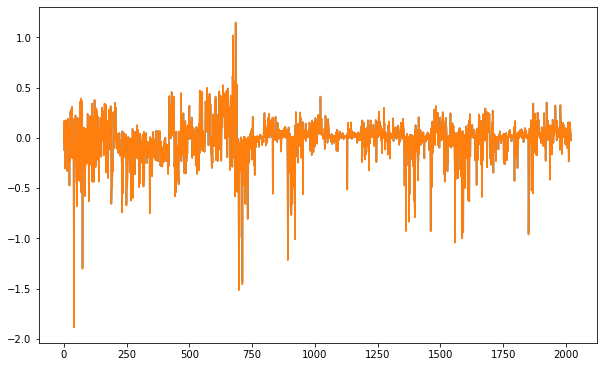

In [73]:
plt.plot(x)
plt.plot(gamma_six_letter_mode11[722])

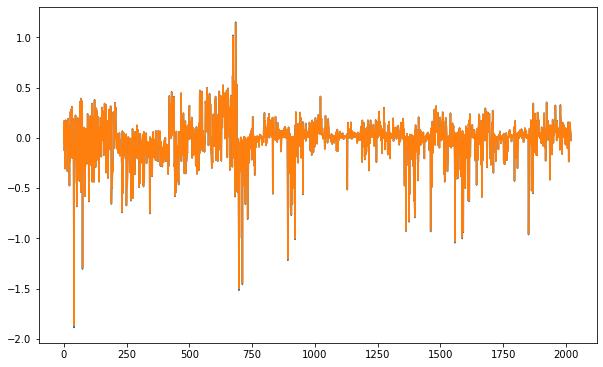

In [74]:

plt.plot(gamma_six_letter_mode11[722])
plt.plot(x)

In [75]:
toLocation = "/Users/weilu/Research/server/sep_2020/membrane_protein_structure_prediction/gamma_folder"
np.savetxt(f"{toLocation}/complete_cutoff722_contact_part.dat", x[:690])
np.savetxt(f"{toLocation}/complete_cutoff722_fourBody_part.dat", -x[690:])

In [102]:
from cvxopt import matrix, solvers
A_B = six_letter_mode11
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
additional_constraint = np.diag([-1]*n)
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
h = matrix([-50, -0]+[15]*n, (2+n, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  1.7888e+04 -8.5698e+04  1e+05  3e-16  1e+03
 1:  1.5346e+04  3.9842e+03  1e+04  1e-15  2e+02
 2:  1.0499e+04  6.6270e+03  4e+03  1e-15  9e+01
 3:  7.6305e+02 -1.2083e+04  1e+04  7e-16  9e+00
 4:  6.0929e+01 -6.5867e+02  7e+02  2e-16  6e-13
 5:  5.5040e+01  4.7359e+01  8e+00  2e-16  2e-13
 6:  5.5019e+01  5.4937e+01  8e-02  2e-16  5e-12
 7:  5.5016e+01  5.5014e+01  1e-03  2e-16  1e-10
 8:  5.5015e+01  5.5015e+01  5e-05  2e-16  2e-09
Optimal solution found.


In [103]:
# z score
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

6.741065395385876 7.417225181521151 50.00000000093696 -0.023619865481372654


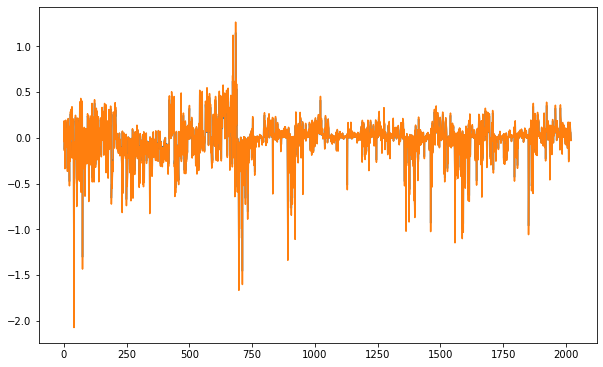

In [104]:
plt.plot(gamma_six_letter_mode11[722])
plt.plot(x)


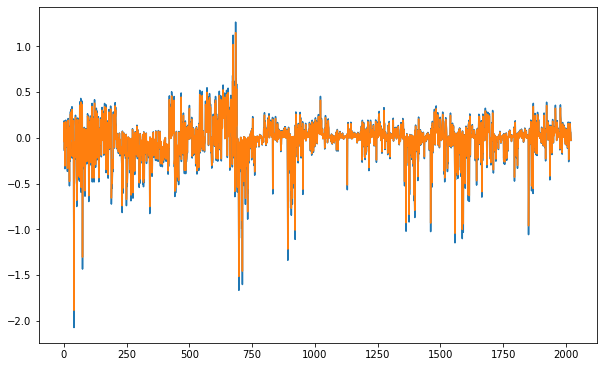

In [105]:
plt.plot(x)
plt.plot(gamma_six_letter_mode11[722])

In [26]:
# cutoff_range=list(range(190, 700, 20)) + list(range(1922, 2022, 10)) 
# cutoff_range=list(range(1622, 2032, 10))
A_B = six_letter_mode11
cutoff_range=list(range(522, 2122, 100)) 
gamma_six_letter_mode11 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

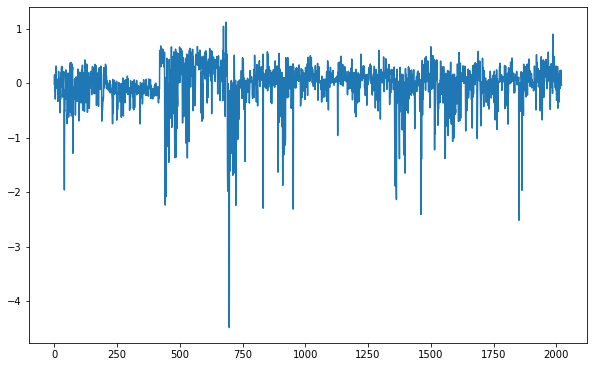

In [29]:
plt.plot(gamma_six_letter_mode11[1222])
# plt.plot(gamma_six_letter_mode10[1222])

In [23]:
# cutoff_range=list(range(190, 700, 20)) + list(range(1922, 2022, 10)) 
# cutoff_range=list(range(1622, 2032, 10))
A_B = six_letter_mode10
cutoff_range=list(range(522, 2122, 100)) 
gamma_six_letter_mode10 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

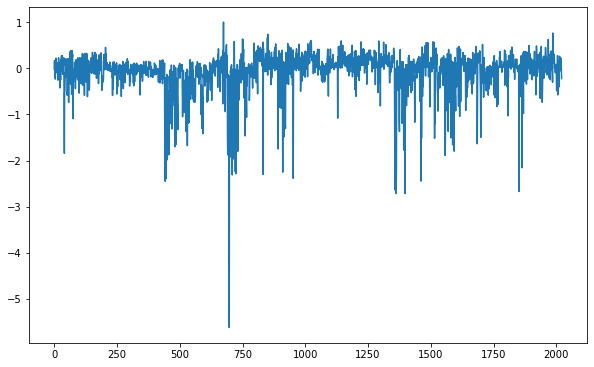

In [24]:
plt.plot(gamma_six_letter_mode10[1222])

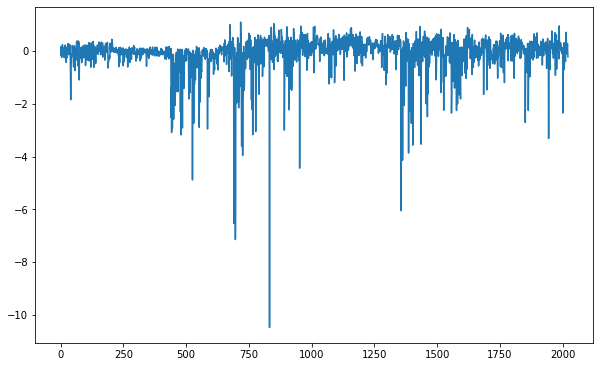

In [25]:
plt.plot(gamma_six_letter_mode10[1722])

In [ ]:
# cutoff_range=list(range(190, 700, 20)) + list(range(1922, 2022, 10)) 
cutoff_range=list(range(1622, 2032, 10)) 
gamma_six_letter_mode10 = get_gamma(A_B['A'], A_B['B'], A_B['A_prime'], c=-0, cutoff_range=cutoff_range)

In [59]:
gamma = gamma_six_letter_mode10[1922]
A_B['A'].dot(gamma) / np.sqrt(gamma.dot(A_B['B']).dot(gamma))

4.829197552897417

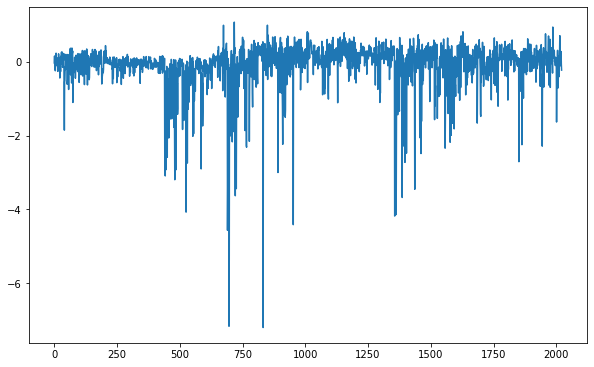

In [60]:
plt.plot(gamma_six_letter_mode10[1622])

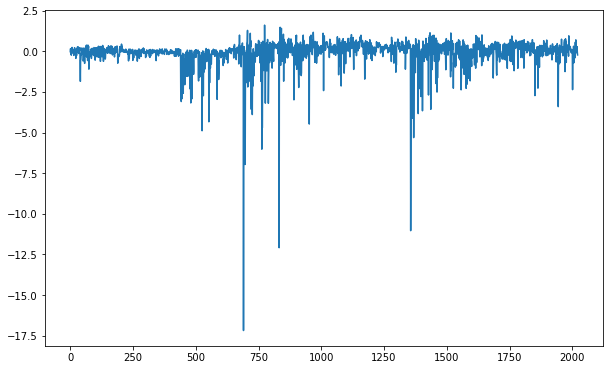

In [57]:
plt.plot(gamma_six_letter_mode10[1922])

In [129]:
B = six_letter_mode10['B']
cutoff = 1800
lamb, P = np.linalg.eig(B)
lamb, P = sort_eigenvalues_and_eigenvectors(lamb, P)
filtered_lamb = np.copy(lamb)
cutoff_mode = cutoff
filtered_B_inv, filtered_lamb, P = get_filtered_B_inv_lambda_and_P(filtered_lamb,
                                                                   cutoff_mode, P)
B_new = np.linalg.inv(filtered_B_inv)

In [137]:
from cvxopt import matrix, solvers
A_B = six_letter_mode10
# B = A_B['B']
B = B_new
A = A_B['A']
A_prime = A_B['A_prime']
n = len(A_prime)

Q = 2*matrix(B)
p = matrix(np.zeros(n))
# G = matrix(-A, (1,n))
# h = matrix(-7.117566, (1, 1), 'd')
additional_constraint = np.diag([-1]*n)
G = matrix(np.concatenate([-A.reshape(1,n), A_prime.reshape(1,n), additional_constraint]), (2+n,n))
h = matrix([-5, -0]+[15]*n, (2+n, 1), 'd')
sol=solvers.qp(Q, p, G=G, h=h)
x = np.array(sol['x']).flatten()

     pcost       dcost       gap    pres   dres
 0:  1.1533e+04 -7.2187e+04  8e+05  1e+00  1e+03
 1:  1.9658e+02 -1.5977e+05  2e+05  3e-01  3e+02
 2:  5.2408e+03 -7.9486e+04  9e+04  5e-02  4e+01
 3:  1.0509e+03 -1.1055e+04  1e+04  5e-03  4e+00
 4:  1.0486e+02 -1.1795e+03  1e+03  3e-04  2e-01
 5:  8.7970e+00 -6.4500e+01  7e+01  6e-06  6e-03
 6:  2.1699e+00 -7.5332e-01  3e+00  9e-08  8e-05
 7:  1.2622e+00  9.7729e-01  3e-01  6e-10  5e-07
 8:  1.1087e+00  1.0727e+00  4e-02  2e-16  5e-12
 9:  1.0824e+00  1.0802e+00  2e-03  2e-16  2e-11
10:  1.0804e+00  1.0804e+00  2e-05  2e-16  3e-10
11:  1.0804e+00  1.0804e+00  2e-07  2e-16  2e-10
Optimal solution found.


In [138]:
# z score
e_std = (np.dot(x, B).dot(x))**0.5
z = A.dot(x) / e_std
print(z, e_std, A.dot(x), A_prime.dot(x))

4.810418906009377 1.0394105165706602 5.000000000016477 -1.7050777584754514e-06


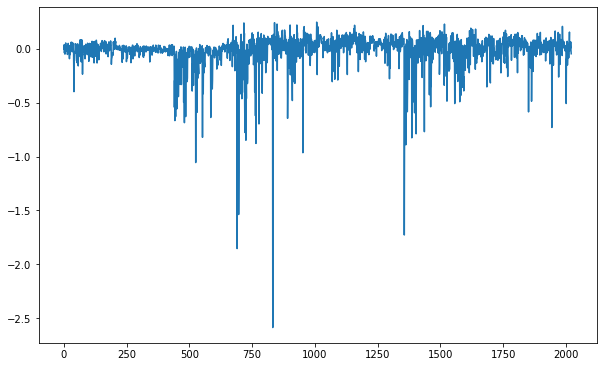

In [139]:
plt.plot(x)

In [140]:
np.argmin(x)

832

In [141]:
x[690]

-1.852848324949107

In [142]:
x[832]

-2.584734417671857

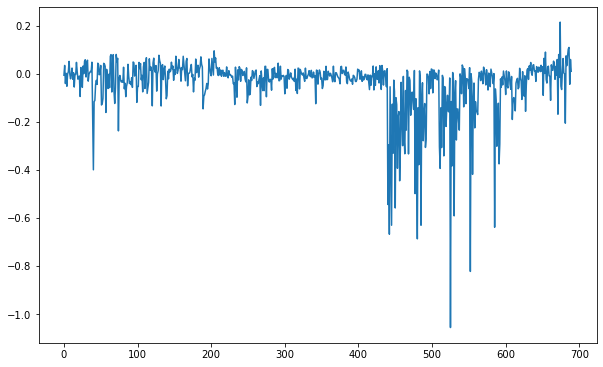

In [143]:
plt.plot(x[:690])

In [145]:
np.savetxt("/Users/weilu/Research/server/sep_2020/membrane_protein_structure_prediction/gamma_folder/complete_contact_part.dat", x[:690])
np.savetxt("/Users/weilu/Research/server/sep_2020/membrane_protein_structure_prediction/gamma_folder/complete_fourBody_part.dat", -x[690:])